## Load the Data

We will first download the DBPedia data and load into a Pandas dataframe.
We drop the `l2` and `l3` columns because we are only interested on `l1` column, to use the first level label (that contains 9 classes).


In [1]:
!curl -L -o dbpedia-classes.zip https://www.kaggle.com/api/v1/datasets/download/danofer/dbpedia-classes

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  165M  100  165M    0     0  97.7M      0  0:00:01  0:00:01 --:--:--  168M


In [2]:
!unzip dbpedia-classes.zip

Archive:  dbpedia-classes.zip
  inflating: DBPEDIA_test.csv        
  inflating: DBPEDIA_train.csv       
  inflating: DBPEDIA_val.csv         
  inflating: DBP_wiki_data.csv       


In [3]:
import pandas as pd

In [4]:
train_df = pd.read_csv("/content/DBPEDIA_train.csv")
test_df = pd.read_csv("/content/DBPEDIA_test.csv")

In [5]:
train_df.drop(columns=["l1", "l3"])
test_df.drop(columns=["l1", "l3"])

,text,l2
0,Liu Chao-shiuan (Chinese: 劉兆玄; pinyin: Liú Zhà...,Politician
1,"Michelle Maylene (born January 20, 1987) is an...",Actor
2,Hirfanlı Dam is a dam in Turkey. The developme...,Infrastructure
3,Grote Prijs Stad Zottegem is a single-day road...,Race
4,"Johannes Petrus \""Hans\"" Nijman (September 23,...",Athlete
...,...,...
60789,Darwin Smith was CEO of Kimberly-Clark from 19...,Person
60790,The HKRU Premiership is the main domestic comp...,SportsLeague
60791,"Leo Harvey Diegel (April 20, 1899 – May 5, 195...",Athlete
60792,"Clement Reginald \""Clem\"" Splatt (17 September...",Athlete


In [6]:
train_df = train_df.rename(columns={"text": "text", "l2": "label"})
test_df = test_df.rename(columns={"text": "text", "l2": "label"})

# Classic Markov

In [7]:
import re
from collections import defaultdict, Counter
import numpy as np
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return word_tokenize(text)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
class MarkovModel:
    def __init__(self):
        self.transitions = defaultdict(Counter)
        self.vocab = set()

    def train(self, texts):
        for text in texts:
            tokens = preprocess(text)
            tokens = ["<START>"] + tokens + ["<END>"]
            self.vocab.update(tokens)
            for i in range(len(tokens) - 1):
                self.transitions[tokens[i]][tokens[i + 1]] += 1

        self.vocab = list(self.vocab)
        self._calculate_probabilities()

    def _calculate_probabilities(self):
        self.probabilities = {}
        for prev_word, next_words in self.transitions.items():
            total = sum(next_words.values())
            self.probabilities[prev_word] = {
                word: count / total for word, count in next_words.items()
            }

    def sequence_log_prob(self, text):
        tokens = preprocess(text)
        tokens = ["<START>"] + tokens + ["<END>"]
        log_prob = 0.0
        for i in range(len(tokens) - 1):
            prev_word = tokens[i]
            next_word = tokens[i + 1]
            prob = self.probabilities.get(prev_word, {}).get(next_word, 1e-6)  # Laplace smoothing
            log_prob += np.log(prob)
        return log_prob


In [9]:
models = {}
classes = train_df['label'].unique()

for cls in classes:
    model = MarkovModel()
    model.train(train_df[train_df['label'] == cls]['text'])
    models[cls] = model


In [10]:
def classify(text, models):
    class_probs = {}
    for cls, model in models.items():
        class_probs[cls] = model.sequence_log_prob(text)
    return max(class_probs, key=class_probs.get)


In [11]:
predictions = [classify(text, models) for text in test_df['text']]
accuracy = np.mean(np.array(predictions) == test_df['label'].values)
print(f"Acurácia (Markov Clássico): {accuracy:.4f}")

Acurácia (Markov Clássico): 0.9013


# Métricas de avaliação do modelo

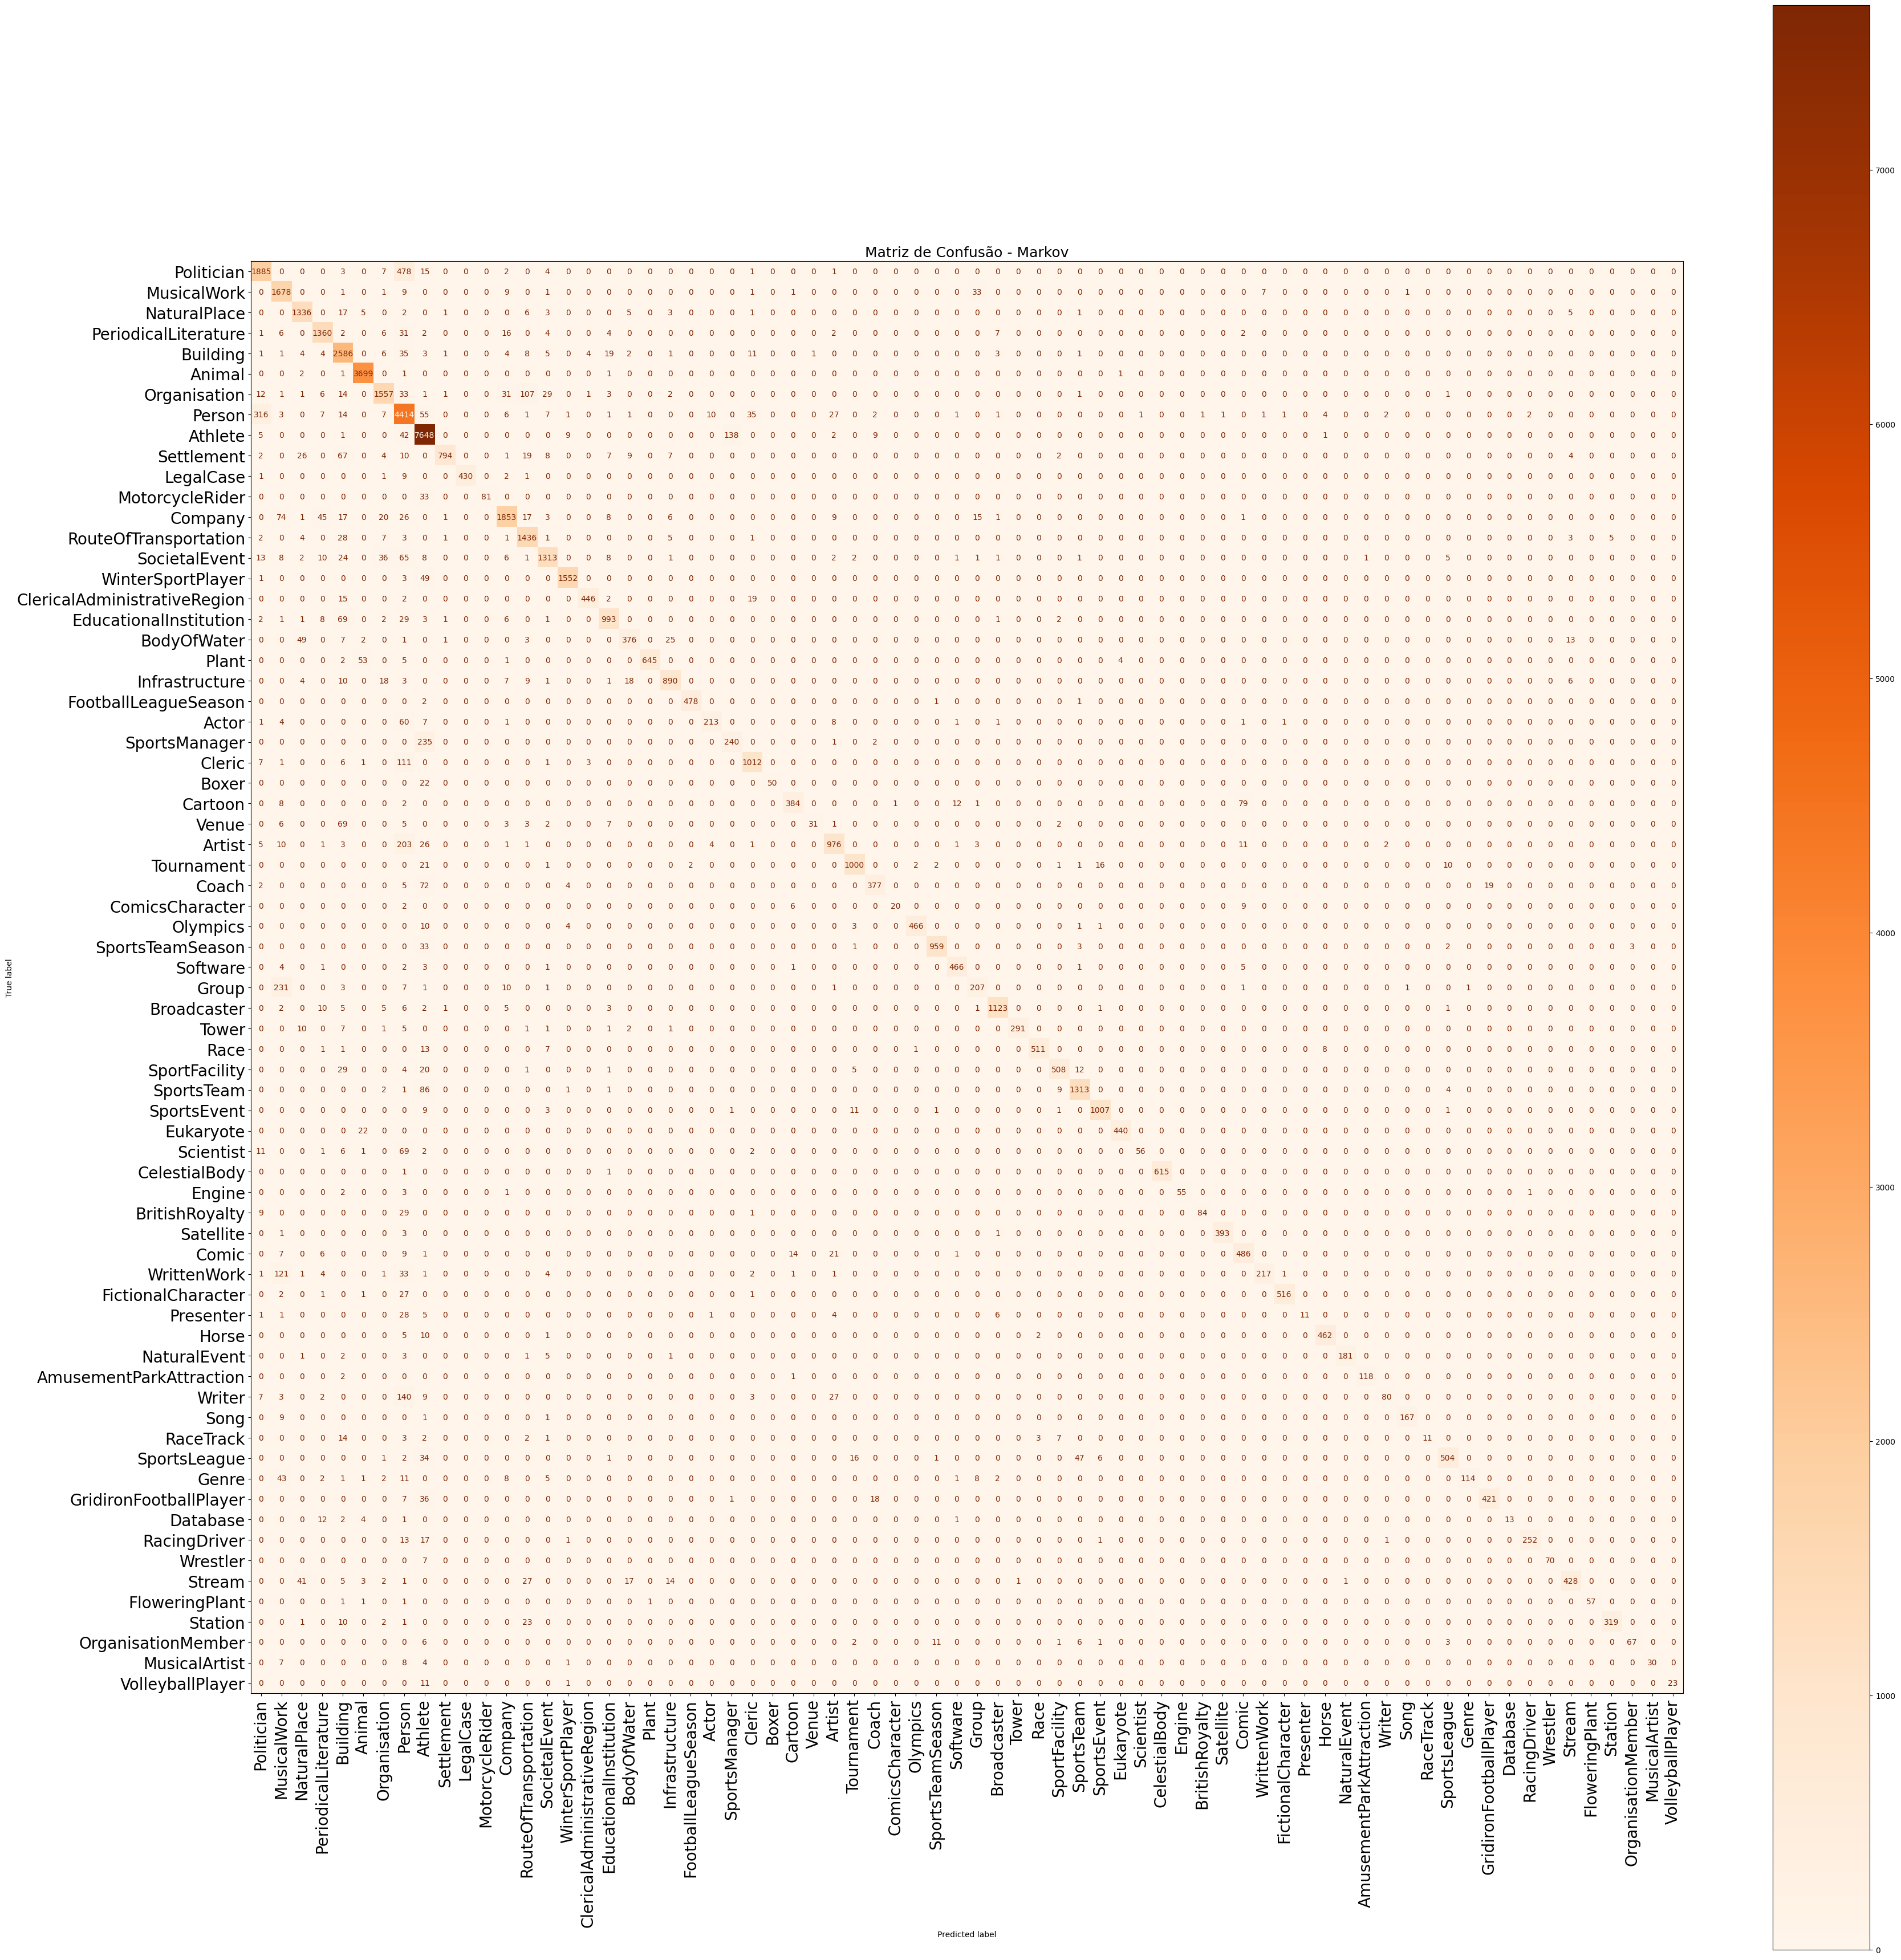

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# gerar matriz de confusao
cm = confusion_matrix(test_df['label'], predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# plotar
fig, ax = plt.subplots(figsize=(36, 36))
disp.plot(xticks_rotation="vertical", cmap="Oranges", values_format='d', ax=ax)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Matriz de Confusão - Markov", fontsize=18)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import classification_report

print(classification_report(test_df['label'], predictions, target_names=classes))

                              precision    recall  f1-score   support

                  Politician       0.93      0.71      0.81       298
                 MusicalWork       0.99      0.98      0.98       121
                NaturalPlace       0.98      1.00      0.99      3705
        PeriodicalLiterature       0.90      0.78      0.84      1248
                    Building       0.90      0.97      0.93      7855
                      Animal       0.87      0.79      0.83       477
                Organisation       1.00      0.69      0.82        72
                      Person       0.99      0.68      0.81       123
                     Athlete       0.98      0.96      0.97      1165
                  Settlement       0.85      0.96      0.90      2700
                   LegalCase       0.94      0.79      0.86       487
             MotorcycleRider       1.00      1.00      1.00       617
                     Company       0.93      0.89      0.91      1142
       RouteOfTrans